
# Deep Learning Architecture

In [1]:
__author__ = "Caroline Ho and Cole Thomson"
__version__ = "CS230, Stanford, Autumn 2018 term"

## Contents
1. [Overview](#Overview)
2. [Set-Up](#Set-Up)
3. [Model](#Model)
5. [Resources](#Resources)

## Overview
Some information here

## Set-Up

In [2]:
%matplotlib inline

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from shutil import copyfile
import random
import time
import os
import copy

plt.ion()   # interactive mode

### Data

Download [Xu et al.'s architecture dataset](https://drive.google.com/file/d/0Bwo0SFiZwl3JVGRlWGZUaW5va00/edit) and place it in the current directory.

We split Xu et al.'s dataset into 80% train/10% dev/10% test.

In [18]:
def set_up_new_dataset(data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    for split in ['train', 'dev', 'test']:
        if not os.path.exists(os.path.join(data_dir, split)):
            os.mkdir(os.path.join(data_dir, split))
            
data_dir = 'data'            
set_up_new_dataset(data_dir)

In [23]:
"""
Description here.
"""
def split_data(old_data_dir, data_dir, train_percent=0.8):
    random.seed(0)
    for directory in os.listdir(old_data_dir):
        if os.path.isfile(os.path.join(old_data_dir, directory)):
            continue
        filenames = os.listdir(os.path.join(old_data_dir, directory))
        filenames.sort()
        random.shuffle(filenames)
        train_split = int(train_percent * len(filenames))
        dev_percent = (1 - train_percent) / 2
        dev_split = int((train_percent + dev_percent) * len(filenames))
        train_filenames = filenames[:train_split]
        dev_filenames = filenames[train_split:dev_split]
        test_filenames = filenames[dev_split:]
        filenames = {'train': train_filenames,
                     'dev': dev_filenames,
                     'test': test_filenames}
        for split in ['train', 'dev', 'test']:
            os.mkdir(os.path.join(data_dir, split, directory))
            for f in filenames[split]:
                copyfile(os.path.join(old_data_dir, directory, f), os.path.join(data_dir, split, directory, f))

old_data_dir = 'arcDataset'
split_data(old_data_dir, data_dir)

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'dev': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'dev', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'dev', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

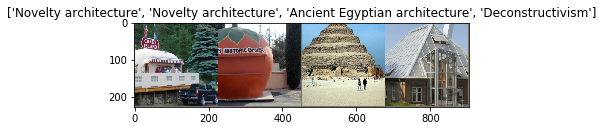

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model
Some stuff here

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best dev Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['dev']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning

In [30]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1935 Acc: 0.3613
dev Loss: 1.5402 Acc: 0.5586

Epoch 1/24
----------
train Loss: 1.8200 Acc: 0.4682
dev Loss: 1.5253 Acc: 0.5941

Epoch 2/24
----------
train Loss: 1.6838 Acc: 0.5166
dev Loss: 1.5919 Acc: 0.5732

Epoch 3/24
----------
train Loss: 1.5538 Acc: 0.5485
dev Loss: 1.5652 Acc: 0.6318

Epoch 4/24
----------
train Loss: 1.5102 Acc: 0.5605
dev Loss: 1.3384 Acc: 0.6757

Epoch 5/24
----------
train Loss: 1.4148 Acc: 0.5935
dev Loss: 1.3228 Acc: 0.6862

Epoch 6/24
----------
train Loss: 1.3510 Acc: 0.6141
dev Loss: 1.3613 Acc: 0.6632

Epoch 7/24
----------
train Loss: 1.0233 Acc: 0.6923
dev Loss: 1.0858 Acc: 0.7322

Epoch 8/24
----------
train Loss: 0.9323 Acc: 0.7218
dev Loss: 1.0502 Acc: 0.7490

Epoch 9/24
----------
train Loss: 0.9319 Acc: 0.7179
dev Loss: 1.0066 Acc: 0.7531

Epoch 10/24
----------
train Loss: 0.8479 Acc: 0.7498
dev Loss: 1.0004 Acc: 0.7469

Epoch 11/24
----------
train Loss: 0.8147 Acc: 0.7613
dev Loss: 1.0221 Acc: 0.7448

Ep

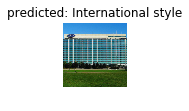

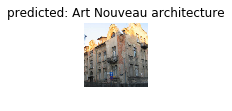

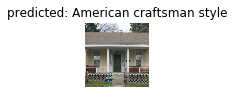

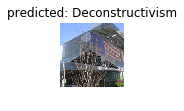

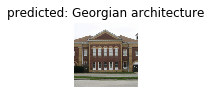

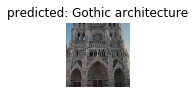

Exception ignored in: <function _DataLoaderIter.__del__ at 0x123572ea0>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 167, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/miniconda2/conda-bld/pytorch_1532624435833/work/torch/lib/libshm/core.cpp:99


In [34]:
visualize_model(model_ft)

### Fixed Feature Extraction

In [35]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 25)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [36]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4823 Acc: 0.2821
dev Loss: 1.7580 Acc: 0.4749

Epoch 1/24
----------
train Loss: 2.0484 Acc: 0.3898
dev Loss: 1.5736 Acc: 0.5105

Epoch 2/24
----------
train Loss: 1.9067 Acc: 0.4261
dev Loss: 1.4769 Acc: 0.5816

Epoch 3/24
----------
train Loss: 1.8199 Acc: 0.4520
dev Loss: 1.5231 Acc: 0.5649

Epoch 4/24
----------
train Loss: 1.7567 Acc: 0.4732
dev Loss: 1.4307 Acc: 0.5921

Epoch 5/24
----------
train Loss: 1.7855 Acc: 0.4706
dev Loss: 1.4775 Acc: 0.5774

Epoch 6/24
----------
train Loss: 1.7714 Acc: 0.4737
dev Loss: 1.4925 Acc: 0.5900

Epoch 7/24
----------
train Loss: 1.5233 Acc: 0.5412
dev Loss: 1.3436 Acc: 0.6151

Epoch 8/24
----------
train Loss: 1.5507 Acc: 0.5302
dev Loss: 1.3248 Acc: 0.6151

Epoch 9/24
----------
train Loss: 1.5595 Acc: 0.5278
dev Loss: 1.3118 Acc: 0.6151

Epoch 10/24
----------
train Loss: 1.5158 Acc: 0.5281
dev Loss: 1.3407 Acc: 0.6109

Epoch 11/24
----------
train Loss: 1.5290 Acc: 0.5352
dev Loss: 1.3034 Acc: 0.6130

Ep

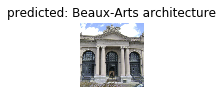

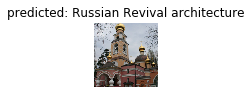

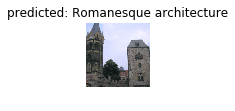

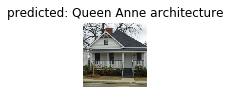

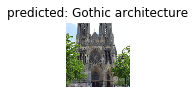

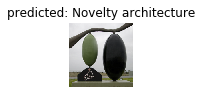

In [37]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Resources

- [CS230 Code Examples](https://github.com/cs230-stanford/cs230-code-examples)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)